# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Импортиурем необходимые нам библиотеки

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords as nltk_stopwords


import torch
import transformers
import spacy

from pymystem3 import Mystem
m = Mystem() 
import re 
from sklearn.feature_extraction.text import CountVectorizer 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.utils import shuffle

Прочитаем файл

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')
#data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

Табличка для записи метрик

In [3]:
d = {'F1 обучения': [], 'F1 предсказания':[]}   
          
summary_table = pd.DataFrame(data=d)
def write_summary_table (col, row, f):
    if row == 0:
        row = 'F1 обучения'
    if row == 1:
        row = 'F1 предсказания'    
    summary_table.loc[col, row] = f

Запишем функцию, оставляющую только буквы

In [4]:
def clear_text(text):
    clear = re.sub(r'[^a-zA-Z]', ' ', text)        
    clear = clear.split()
    clear_text = " ".join(clear)
    return clear_text

 Напишем функцию лемматизации текста

In [5]:
nlp = spacy.load('en_core_web_sm')

def lemmatize_spacy(sentence):    
    doc = nlp(sentence)
    lemm_text = " ".join([token.lemma_ for token in doc])
    return lemm_text

In [6]:
data['clear_text'] = data['text'].apply(lambda x: clear_text(x))

In [7]:
%%time
start = time.time()
data['lemm_text'] = data['clear_text'].apply(lambda x: lemmatize_spacy(x))
end = time.time()
print(end-start)

1766.195801973343
CPU times: user 28min 49s, sys: 20.7 s, total: 29min 10s
Wall time: 29min 26s


Итоги записываем в файл

In [8]:
data.to_csv('lemm_text.csv', index=False)

In [9]:
print("Исходный текст:", data['text'][0])
print("Лемматизированный текст:", data['lemm_text'][0])

Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Лемматизированный текст: explanation why the edit make under -PRON- username Hardcore Metallica Fan be revert -PRON- weren t vandalism just closure on some gas after -PRON- vote at New York Dolls FAC and please don t remove the template from the talk page since -PRON- m retire now


Разобъём выборку на фичи и таргеты

In [10]:
features = data['lemm_text']
target = data['toxic']
features_train,features_test,target_train,target_test = train_test_split(features,target,test_size = 0.25,random_state = 12345,stratify = target)


Рассмотрим распределение признака

0    143346
1     16225
Name: toxic, dtype: int64


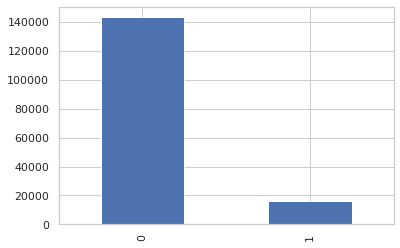

In [11]:
class_frequency = data['toxic'].value_counts()
print(class_frequency)
class_frequency.plot(kind='bar') 

Признак не сбалансирован, что может помешать обучению модели. Количество позитивных комментариев в девять раз больше негативных.



# TF-IDF

Для обучения модели преобразуем тексты в векторную форму.
Столбец признаков будет являться корпусом слов, который мы трансформируем в матрицу и посчитаем величину TF-IDF.

Создадим переменные для признака и целевого признака.

In [12]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159571 entries, 0 to 159570
Data columns (total 4 columns):
text          159571 non-null object
toxic         159571 non-null int64
clear_text    159571 non-null object
lemm_text     159571 non-null object
dtypes: int64(1), object(3)
memory usage: 6.1+ MB


In [13]:
features = data['lemm_text']
target = data['toxic']

Разобьем датасет на обучающую и тестовую выборку в соотношении 80-20

In [14]:
train_corpus, test_corpus, target_train, target_test = train_test_split(features,target,test_size=0.2)

print('Размер обучающей выборки:', len(train_corpus))
print('Размер тестовой выборки:', len(test_corpus))

Размер обучающей выборки: 127656
Размер тестовой выборки: 31915


Создадим счётчик стоп-слов (матерных)

In [15]:
stopwords = set(nltk_stopwords.words('english'))

Создадим счетчик tf_idf, который выделит из корпуса уникальные слова и посчитает количество их вхождений в каждом тексте корпуса.

In [16]:
tf_idf = TfidfVectorizer(stop_words=stopwords, lowercase=True, min_df=0.0001)
features_train = tf_idf.fit_transform(train_corpus)
features_test = tf_idf.transform(test_corpus)

In [17]:
features_train.shape

(127656, 13359)

In [18]:
target_train.shape

(127656,)

# Обучение моделей

Рассмотрим результат работы модели без балансировки классов. Для эксперимента возьмем логистическую регрессию.

In [19]:
model = LogisticRegression()
parameters = {'solver': ['liblinear']}

grid = GridSearchCV(model, parameters, cv = None, scoring = 'f1')
grid.fit(features_train, target_train)
predicted_test = grid.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))

F1: 0.7407829722538958


Метрика f1 достигла 75, что в принципе является минимальным допустимым для нас результатом.

Попробуем увеличить качество модели с помощью взвешивания классов

In [20]:
model = LogisticRegression()
parameters = {'solver': ['liblinear'], 'class_weight': ['balanced']}
grid = GridSearchCV(model, parameters, cv = None, scoring = 'f1')
grid.fit(features_train, target_train)
predicted_test = grid.predict(features_test)
print("F1:", f1_score(target_test, predicted_test))

F1: 0.7334772052872943


Попробуем уменьшить число позитивных комментариев. Можно было бы увеличить число отрицательных, но датасет слишком разрастется.
Если приравнять число позитивных комментариев к негативным, мы потеряем большую часть данных.
Попробуем отрезать только часть позитивных, например, оставим одну треть из них.

In [21]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction)] + [features_ones])
    
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled)
    
    return features_downsampled, target_downsampled

In [22]:
features_downsampled, target_downsampled = downsample(train_corpus, target_train, 0.3)

In [23]:
tf_idf = TfidfVectorizer(stop_words=stopwords, lowercase=True, min_df=0.0001)
features_downsampled = tf_idf.fit_transform(features_downsampled)
features_test = tf_idf.transform(test_corpus)

0    34381
1    13052
Name: toxic, dtype: int64


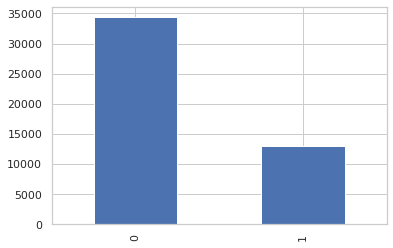

In [24]:
class_frequency = target_downsampled.value_counts(normalize=False)
print(class_frequency)
class_frequency.plot(kind='bar') 

Далее обучим модели на признаках features_downsampled

In [25]:
model = LogisticRegression()
parameters = {'solver': ['liblinear']}
grid = GridSearchCV(model, parameters, cv = None, scoring = 'f1')
grid.fit(features_downsampled, target_downsampled)
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

write_summary_table('LogisticRegression', 0, grid.best_score_)

0.8171241294730313
{'solver': 'liblinear'}
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


In [26]:
f1 = f1_score(grid.predict(features_test),target_test)
print(f1)
write_summary_table('LogisticRegression', 1, f1)

0.7650700553926361


Вывод : получили значение метрики f1 равное 0.77, меняя большое количество гиперпараметров.

# LGBMClassifier

In [27]:
model = LGBMClassifier()
parameters = {
   # 'objective':['binary'],
    #'num_leaves': [31]
    'n_estimators': [100]
     
}

In [28]:
grid = GridSearchCV(model, parameters, cv = None, scoring = 'f1')
grid.fit(features_downsampled, target_downsampled)
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

write_summary_table('LGBM', 0, grid.best_score_)

0.8257412533828157
{'n_estimators': 100}
LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [29]:
f1 = f1_score(grid.predict(features_test),target_test)
print(f1)
write_summary_table('LGBM', 1, f1)

0.7626498002663116


Вывод : получили значение метрики f1 равное 0.77, чуть ниже, чем у модели Логистической регрессии.

# CatBoost

In [30]:
model = CatBoostClassifier()

parameters = {    
   # 'learning_rate': [0.1],
    'iterations': [100], #[40, 60, 100, 200, 500]
    #depth': [10],  #[5, 7, 10]    
    'verbose': [200]}

In [31]:
grid = GridSearchCV(model, parameters, cv = None, scoring = 'f1')
grid.fit(features_downsampled, target_downsampled)
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
write_summary_table('CatBoost', 0, grid.best_score_)

Learning rate set to 0.346431
0:	learn: 0.5464513	total: 1.15s	remaining: 1m 54s
99:	learn: 0.2047590	total: 1m 29s	remaining: 0us
Learning rate set to 0.346435
0:	learn: 0.5463946	total: 960ms	remaining: 1m 35s
99:	learn: 0.2027913	total: 1m 32s	remaining: 0us
Learning rate set to 0.346438
0:	learn: 0.5413098	total: 955ms	remaining: 1m 34s
99:	learn: 0.1995172	total: 1m 27s	remaining: 0us
Learning rate set to 0.388557
0:	learn: 0.5261636	total: 1.72s	remaining: 2m 50s
99:	learn: 0.2006673	total: 1m 55s	remaining: 0us
0.8154707159700482
{'iterations': 100, 'verbose': 200}


In [32]:
f1 = f1_score(grid.predict(features_test),target_test)
print(f1)
write_summary_table('CatBoost', 1, f1)

0.761745527503762


Вывод : получили самое большое значение метрики f1

# DecisionTreeClassifier

In [33]:
model = DecisionTreeClassifier()

parameters = {'max_depth': range(4,16,2)}

In [34]:
grid = GridSearchCV(model, parameters, cv = None, scoring = 'f1')
grid.fit(features_downsampled, target_downsampled)
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)
write_summary_table('DecisionTreeClassifier', 0, grid.best_score_)

0.6656519119078194
{'max_depth': 14}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [35]:
f1 = f1_score(grid.predict(features_test),target_test)
print(f1)
write_summary_table('DecisionTreeClassifier', 1, f1)

0.6268065729558504


Вывод : в этой модели значения метрик f1 самые маленькие.

In [36]:
summary_table

,F1 обучения,F1 предсказания
LogisticRegression,0.817124,0.765070
LGBM,0.825741,0.762650
CatBoost,0.815471,0.761746
DecisionTreeClassifier,0.665652,0.626807


## Выводы

Мы лемматизировали текст, трансформировали текстовую колонку в матрицу и посчитали величину TF-IDF.
Обучили модели классифицировать комментарии на позитивные и токсичные.
Лучшие результаты показала модель логистической регрессии, для нее достаточным оказалось только очистить и лемматизировать исходные данные, чтобы получить метрику качества F1 выше 0,75
На уменьшенной выборке хорошие метрики оказались у моделей классификации CatBoost (0,77) и LGBM (0,77).

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей